In [73]:
import numpy as np
from tqdm import tqdm
import pickle
from sklearn.metrics import f1_score, precision_score, recall_score
from matplotlib import pyplot as plt
from utils import top_n
from typing import Tuple

Загружаем рассчитанные эмбеддинги

In [74]:
with open('embeddings_dict.pickle', 'rb') as f:
    emb_dict = pickle.load(f)


Если считать каждую пару за класс, то всего будет порядка 8 тысяч классов, мы считаем топ 1 ошибку и топ 5 ошибку для задачи классификации из 8 тысяч классов

In [75]:
top1 = top_n(emb_dict[0], emb_dict[1], 1)
top5 = top_n(emb_dict[0], emb_dict[1], 5)


print(f"top1 = {top1:.2f}\ntop5 = {top5:.2f}")

top1 = 0.76
top5 = 0.92


Функция, которая возвращает 2 массива индексов для сравнения, половина из них является парой: эталлонной и положительной к ней, а вторая половина эталлонной и отрицательной к ней

In [76]:
def gen_ids_to_calc_accuracy(N : int) -> Tuple[np.array] :
    idx_etalon = np.arange(N)
    idx_rand = np.random.permutation(N)
    while not np.all(idx_rand != idx_etalon):
        idx_rand = np.random.permutation(N)
    
    list_idx1 = np.concatenate((idx_etalon, idx_rand))
    list_idx2 = np.concatenate((idx_etalon, idx_etalon))
    return list_idx1, list_idx2

In [77]:
list_idx1, list_idx2 =  gen_ids_to_calc_accuracy(len(emb_dict[0]))


Далее мы расситываем пресижен и рекол кривые по порогу принятия решения

In [78]:
thres = np.arange(20)/20
accurs = []
pres = []
recall = []
for th in tqdm(thres):
    labels = []
    lvls = []
    for i, j in zip(list_idx1, list_idx2):
        cos_sim = np.dot(emb_dict[0][i], emb_dict[1][j])/(np.linalg.norm(emb_dict[0][i])*np.linalg.norm(emb_dict[1][j]))
        lvl = (cos_sim + 1)/2
        lvls.append(int(lvl > th))
        labels.append(int(i==j))
    accurs.append(f1_score(lvls, labels))
    pres.append(precision_score(lvls, labels))
    recall.append(recall_score(lvls, labels))

100%|██████████| 20/20 [00:02<00:00,  7.80it/s]


Выводим максимальную точность и лучший порог принятия решения

In [79]:
thr_max = thres[np.argmax(accurs)]
f1_max = np.max(accurs)

print(f"threshold of max f1 = {thr_max:.2f}\nmax f1 = {f1_max:.2f}")

threshold of max f1 = 0.75
max f1 = 0.98


рисуем график для ф1 присижена и рекола по порогу принятия решения

Text(0, 0.5, 'accuracy')

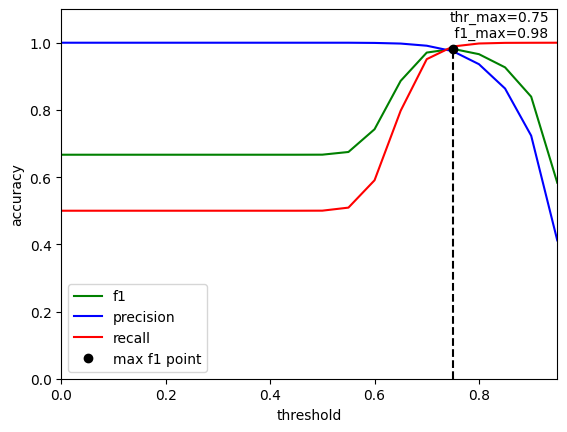

In [80]:
plt.plot(thres, accurs, "g", label="f1")
plt.plot(thres, pres, "b", label="precision")
plt.plot(thres, recall, "r", label="recall")

# Plot the point for max f1
plt.plot([thr_max, thr_max], [0, f1_max], "k--")
plt.plot([thr_max], [f1_max], "ko", label="max f1 point")

# Annotate the point with thr_max and f1_max values
plt.annotate(f"thr_max={thr_max:.2f}\n f1_max={f1_max:.2f}",
            xy=(thr_max - 0.014, f1_max + 0.014), xytext=(3, 3),
            textcoords="offset points", ha="left", va="bottom")

plt.legend(loc="best")
plt.ylim(0.0, 1.1)
plt.xlim(0.0, np.max(thres))
plt.xlabel('threshold')
plt.ylabel('accuracy')